## ライブラリの読み込み

In [1]:
import datetime
import numpy as np
import pandas as pd
import pandas_datareader.data as web
import matplotlib.pyplot as plt
import japanize_matplotlib

## データの取得

In [2]:
toyota_code = '7203.T'
start = datetime.date(2012, 1, 1)

day_df = web.DataReader(toyota_code, 'yahoo', start)
print('欠損値の確認')
print(day_df.isnull().sum())
print('形状の確認', day_df.shape)
day_df.tail()

欠損値の確認
High         0
Low          0
Open         0
Close        0
Volume       0
Adj Close    0
dtype: int64
形状の確認 (2532, 6)


,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2022-04-01,2238.0,2174.5,2222.5,2205.0,27719800.0,2205.0
2022-04-04,2213.5,2192.0,2193.0,2211.0,16276100.0,2211.0
2022-04-05,2236.0,2202.5,2231.0,2217.5,21878700.0,2217.5
2022-04-06,2201.5,2176.0,2192.0,2190.0,28164400.0,2190.0
2022-04-07,2173.0,2132.0,2166.0,2153.0,12718300.0,2153.0


## リターンの計算

In [3]:
day_df['PrevClose'] = day_df['Close'].shift(1)
day_df['Return'] = (day_df['Close'] - day_df['PrevClose']) / day_df['PrevClose']

## 固定時間ホライズン法によるラべリング

In [46]:
def fixed_time_horizon(data, threshold):
    '''
    data: pd.Seriesのリターンデータ
    threshold: 閾値
    '''
    label_df = pd.DataFrame(index=data.index, columns=['Return', 'Label'])
    
    idx_lower = data[data < -threshold].index
    idx_middle = data[abs(data) <= threshold].index
    idx_upper = data[data > threshold].index
    
    label_df['Return'] = data
    label_df.loc[idx_lower, 'Label'] = -1
    label_df.loc[idx_middle, 'Label'] = 0
    label_df.loc[idx_upper, 'Label'] = 1
    
    return label_df

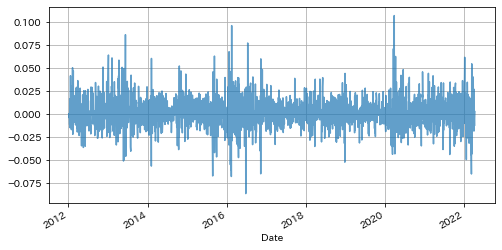

In [47]:
day_df['Return'].plot(figsize=(8, 4), alpha=0.7)
plt.grid(True)
plt.show()

,Return,Label
Date,,
2012-01-05,0.000000,0
2012-01-06,-0.002269,-1
2012-01-10,-0.004549,-1
2012-01-11,0.000000,0
2012-01-12,-0.011805,-1


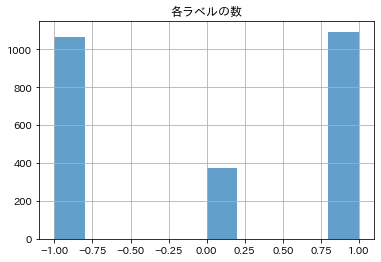

In [50]:
day_df_dropped = day_df.dropna()
label_df = fixed_time_horizon(day_df_dropped['Return'], 0.002)
display(label_df.head())
plt.hist(label_df['Label'], alpha=0.7)
plt.title('各ラベルの数')
plt.grid(True)
plt.show()

## 動的閾値を計算するための関数

In [7]:
def get_daily_vol(close, span0=100):
    # 日次ボラティリティ、close(株価系列)に従いインデックスを再編成
    df0 = close.index.searchsorted(close.index - pd.Timedelta(days=1))
    df0 = df0[df0 > 0]
    df0 = pd.Series(close.index[df0 - 1], index=close.index[close.shape[0] - df0.shape[0]:])
    # 日次リターン
    df0 = close.loc[df0.index] / close.loc[df0.values].values - 1
    df0 = df0.ewm(span=span0).std()
    return df0

In [8]:
x = get_daily_vol(day_df['Close'])

In [10]:
x.head()

Date
2012-01-06         NaN
2012-01-10    0.001612
2012-01-11    0.001309
2012-01-12    0.004178
2012-01-13    0.005812
Name: Close, dtype: float64